In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation
from sklearn.datasets import make_blobs

from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_utilities, plot_decision_boundary

from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.pool import CoreSet, TypiClust, Badge

In [2]:
random_state = np.random.RandomState(0)

# Build a dataset.
X, y_true = make_blobs(n_samples=200, n_features=2,
                       centers=[[0, 1], [-3, .5], [-1, -1], [2, 1], [1, -.5]],
                        cluster_std=.7, random_state=random_state)
y_true = y_true % 2
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

/Users/chengjiaying/scikit-activeml/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chengjiaying/scikit-activeml/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chengjiaying/scikit-activeml/skactiveml/visualization/_feature_space.py:676: UserWarning: Unable to create utility plot with mesh because of the following error. Trying plotting over candidates. 

 Unexpected IndexError('index 200 is out of bounds for axis 0 with size 200')
  warnings.warn(
/Users/chengjiaying/scikit-activeml/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:

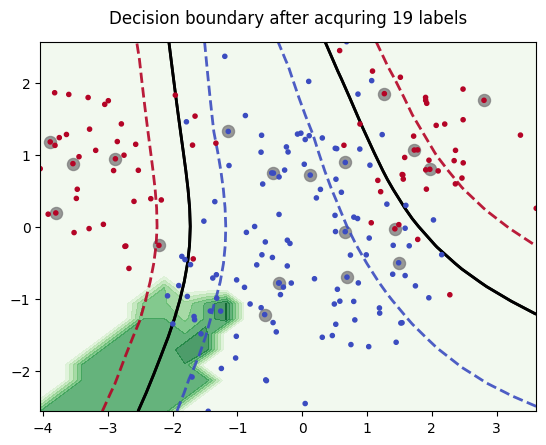

In [3]:
# Initialise the classifier.
clf = ParzenWindowClassifier(classes=[0, 1], random_state=random_state)
# Initialise the query strategy.
qs_coreset = CoreSet()
qs_typiclust = TypiClust()
qs_badge = Badge()

# Preparation for plotting.
fig, ax = plt.subplots()
feature_bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
artists = []

# The active learning cycle:
n_cycles = 20
for c in range(n_cycles):
    # Fit the classifier.
    clf.fit(X, y)

    # Get labeled instances.
    X_labeled = X[labeled_indices(y)]
    
    # Query the next instance/s.
    query_idx = qs_typiclust.query(X=X, y=y)

    # Plot the labeled data.
    coll_old = list(ax.collections)
    title = ax.text(
        0.5, 1.05, f"Decision boundary after acquring {c} labels",
        size=plt.rcParams["axes.titlesize"], ha="center",
        transform=ax.transAxes
    )
    ax = plot_utilities(qs_typiclust, X=X, y=y,
                        candidates=None, res=25,
                        feature_bound=feature_bound, ax=ax)
    ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap="coolwarm", marker=".",
               zorder=2)
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c="grey", alpha=.8,
               marker=".", s=300)
    ax = plot_decision_boundary(clf, feature_bound, ax=ax)

    coll_new = list(ax.collections)
    coll_new.append(title)
    artists.append([x for x in coll_new if (x not in coll_old)])
    
    # Label the queried instances.
    y[query_idx] = y_true[query_idx]

ani = animation.ArtistAnimation(fig, artists, interval=1000, blit=True)
f = r"/Users/chengjiaying/scikit-activeml/tutorials/typiclust.gif" 
ani.save(f)